# Multispectrum Sensor Raw Data Processing

The AS7341 datasheet is [here](https://github.com/dkirkby/E4S/blob/main/datasheets/multispec.pdf) and the Adafruit module product page is [here](https://learn.adafruit.com/adafruit-as7341-10-channel-light-color-sensor-breakout?view=all).

Fig. 18 of the datasheet shows a key plot for interpreting the measured flux values, but does not provide the relevant numeric data.

Use [this web tool](https://apps.automeris.io/wpd/) to extract the datapoints from this curve and load the resulting CSV file to reproduce the figure:

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import scipy.interpolate

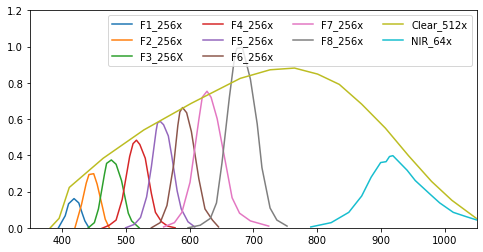

In [4]:
def load(file='Multispec-curves.csv'):
    """Read datapoints captured using https://apps.automeris.io/wpd/
    """
    with open(file) as f:
        lines = f.readlines()
    columns = lines[0].strip().split(',')[::2]
    ncol = len(columns)
    nrow = len(lines)-2
    raw = np.full((nrow, 2 * ncol), np.nan)
    for irow, line in enumerate(lines[2:]):
        row = line.strip().split(',')
        assert len(row) == 2 * ncol
        for icol in range(2 * ncol):
            try:
                raw[irow,icol] = float(row[icol])
            except:
                pass
    x = raw[:,0::2].T
    y = raw[:,1::2].T
    nan = np.isnan(x)
    data = {columns[k]: [x[k, ~nan[k]],y[k, ~nan[k]]] for k in range(ncol)}
    
    fig = plt.figure(figsize=(8, 4))
    for (name, (x,y)) in data.items():
        plt.plot(x, y, label=name)
    plt.legend(ncol=4)
    plt.xlim(350, 1050)
    plt.ylim(0, 1.2)
    
    return data
    
data = load()

Tabulate the gains corresponding to each filter curve:

In [5]:
gains = [256] * 8 + [512, 64]

Our goal is to convert the flux measured in each filter band into a model of the continuous spectrum that would be measured by an ideal detector.

We will restrict our attention to the 8 narrow bands, ignoring the "Clear" and "NIR" channels. Since we only have 8 measurements, our continous spectrum model should have 8 parameters, in order to avoid an over- or under-determined system of equations to solve.

Adopt a model that is piece-wise linear between 8 fixed wavelengths, so the model parameters are the fluxes at each fixed wavelength:

In [6]:
wlen_linear = np.linspace(420, 680, 8)

Write a function to calculate the predicted fluxes in each of the 8 bands given the 8 linear model flux parameters:

In [7]:
def get_linear_pred(linear_flux):
    wlen = np.linspace(390, 750, 1000)
    model = scipy.interpolate.interp1d(
        wlen_linear, linear_flux, copy=False, assume_sorted=True, fill_value='extrapolate')
    model_flux = model(wlen)
    bands = list(data.keys())[:len(wlen_linear)]
    nbands = len(bands)
    band_flux = np.empty(nbands)
    for i, band in enumerate(bands):
        xf, yf = data[band]
        filt = np.interp(wlen, xf, yf, 0., 0.) * (256 / gains[i])
        band_flux[i] = np.trapz(model_flux * filt, wlen)
    return band_flux
    
get_linear_pred(np.random.uniform(size=len(wlen_linear)))

array([ 1.95665397,  3.3463889 ,  7.7833288 ,  9.36794985,  4.94059683,
        9.53591585, 22.58615984, 51.23983762])

This model is actually linear (since interpolation and convolution on a fine wavelength grid are both linear), so can be represented as an 8 x 8 matrix multiplication:

In [8]:
def get_matrix(linear_flux0, delta=1e-3):
    # Change each band flux by +/-delta
    npar = len(wlen_linear)
    assert len(linear_flux0) == npar
    matrix = np.zeros((npar, npar))
    for i in range(npar):
        for sign in (+1,-1):
            linear_flux = np.array(linear_flux0)
            linear_flux[i] += sign * delta
            band_flux = get_linear_pred(linear_flux)
            matrix[i] += sign * band_flux
        matrix[i] /= (2 * delta)
    return matrix.T
            
matrix = get_matrix(np.zeros(len(wlen_linear)))

Verify that this really is a linear model:

In [9]:
matrix2 = get_matrix(np.random.uniform(size=len(wlen_linear)))
assert np.allclose(matrix, matrix2)

In [10]:
linear_flux = np.random.uniform(size=len(wlen_linear))
band_flux = get_linear_pred(linear_flux)
band_flux2 = matrix.dot(linear_flux)
assert np.allclose(band_flux, band_flux2)

Calculate the inverse (linear) transformation from measured band fluxes to linear model fluxes:

In [11]:
inverse = np.linalg.inv(matrix)

Calculate the linear model parameters, then evaluate and plot the model on a grid of wavelengths:

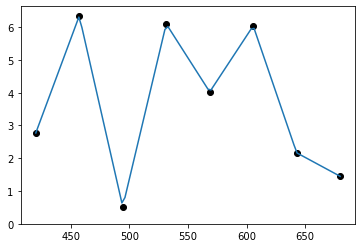

In [12]:
def plot_linear_flux(band_flux, nwlen=100):
    linear_flux = inverse.dot(band_flux)
    plt.plot(wlen_linear, linear_flux, 'ko')
    wlen = np.linspace(wlen_linear[0], wlen_linear[-1], nwlen)
    flux = np.interp(wlen, wlen_linear, linear_flux)
    plt.plot(wlen, flux)
    plt.ylim(0)

plot_linear_flux([11.000,45.000,43.000,76.625,117.750,137.250,144.375,79.250])

Note that using the inverse of a matrix with some noise (as we are doing here) introduces some "ringing" oscillations into the solution.

Print the inverse matrix elements in a format suitable for cut-and-paste into the microcontroller code:

In [13]:
for row in inverse:
    fmt = ', '.join([f'{x:.5g}' for x in row])
    print(f'\t[{fmt}],')

	[0.22405, 0.0070204, -0.00019178, 7.0214e-06, -5.5096e-07, 6.1549e-08, -5.3523e-09, 5.3565e-10],
	[-0.10948, 0.17198, -0.0046982, 0.00017201, -1.3497e-05, 1.5078e-06, -1.3112e-07, 1.3122e-08],
	[0.082699, -0.13312, 0.13831, -0.0050636, 0.00039733, -4.4386e-05, 3.8599e-06, -3.8629e-07],
	[-0.058369, 0.094059, -0.10195, 0.10065, -0.007898, 0.0008823, -7.6726e-05, 7.6785e-06],
	[0.036403, -0.058665, 0.06372, -0.065853, 0.08282, -0.0094219, 0.00081938, -8.2002e-05],
	[-0.025095, 0.040442, -0.043931, 0.04551, -0.059966, 0.07946, -0.0069283, 0.00069337],
	[0.01624, -0.026172, 0.02843, -0.02946, 0.039023, -0.058678, 0.056136, -0.0056246],
	[0.0012445, -0.0020056, 0.0021787, -0.0022575, 0.0029879, -0.0044096, 0.003658, 0.016792],
